In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import seaborn as sns

In [2]:
btc_price = pd.read_csv("bitcoin_2010-07-17_2022-07-28.csv")
nasdaq_100_price = pd.read_csv("nasdaq.csv")
# vgt_price = pd.read_csv("VGT.csv")

def set_date_as_index(price):
  price["Date"] = pd.to_datetime(price["Date"])
  price = price.set_index("Date")
  return price

def get_daily_price(price, name):
  price = (price["High"]+price["Low"])/2
  return pd.DataFrame(price, index=price.index, columns=[name])

def select_common_end_points(price1, price2):  
  return price1.join(price2, how='outer')



In [3]:
price = select_common_end_points(get_daily_price(set_date_as_index(btc_price), "BTC"),
                         get_daily_price(set_date_as_index(nasdaq_100_price), "NDX"))

# price = select_common_end_points(price, get_daily_price(set_date_as_index(vgt_price), "VGT"))

In [4]:
def get_monthly_price(price):
  monthly_price = price.copy()
  monthly_price.index = monthly_price.index.to_period('M')
  monthly_price.index = monthly_price.index.to_timestamp()
  monthly_price = monthly_price.groupby(monthly_price.index).mean()
  return monthly_price

def get_annual_price(price):
  annual_price = price.copy()
  annual_price.index = annual_price.index.to_period('Y')
  annual_price = annual_price.groupby(annual_price.index).mean()
  return annual_price

def get_returns(price):
  return (price - price.shift(1))/price.shift(1)

In [5]:
monthly_price = get_monthly_price(price)
annual_price = get_annual_price(price).dropna()
daily_returns = get_returns(price).dropna()
monthly_returns = get_returns(monthly_price).dropna()

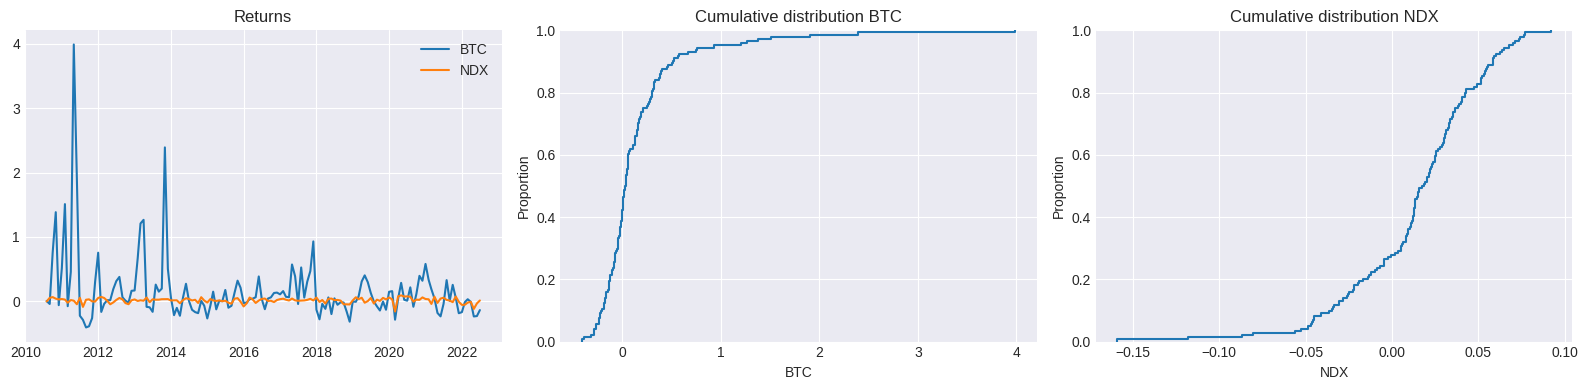

In [6]:
plt.style.use("seaborn-darkgrid")
cols = [1,2,3]

fig, axes = plt.subplots(1, 3,figsize=(16,4))
# plt.figure()
axes = axes.ravel() 

# sns.histplot(data=penguins[col], kde=True, stat='density', ax=ax)

for col, ax in zip(cols, axes):
  if col == 1:
    ax.plot(monthly_returns)
    ax.set_title("Returns")
    ax.legend(['BTC', 'NDX'])
  elif col == 2:
    sns.ecdfplot(monthly_returns['BTC'], ax=ax)
    ax.set_title("Cumulative distribution BTC")
  else:
    sns.ecdfplot(monthly_returns['NDX'], ax=ax)
    ax.set_title("Cumulative distribution NDX")    
    
fig.tight_layout()
plt.savefig("return_distribution", dpi=300)
plt.show()

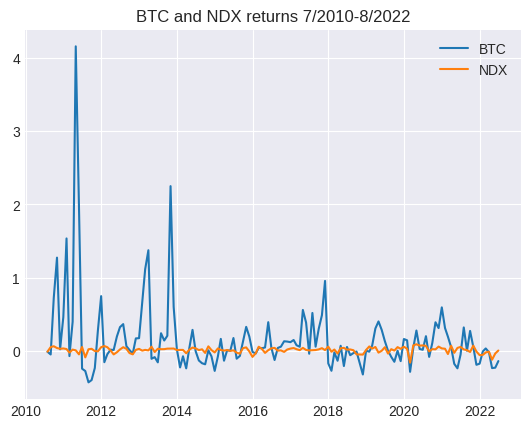

In [64]:
plt.plot(monthly_returns)
plt.title("BTC and NDX returns 7/2010-8/2022")
plt.legend(['BTC', 'NDX'])
plt.savefig("btc_ndx_returns", dpi=300)
plt.show()

In [ ]:


# sns.ecdfplot(monthly_returns['BTC'])
# plt.fill_between(btc_x,btc_y, 0.8, where = btc_x >=0.30160147, color='g')
# plt.show()

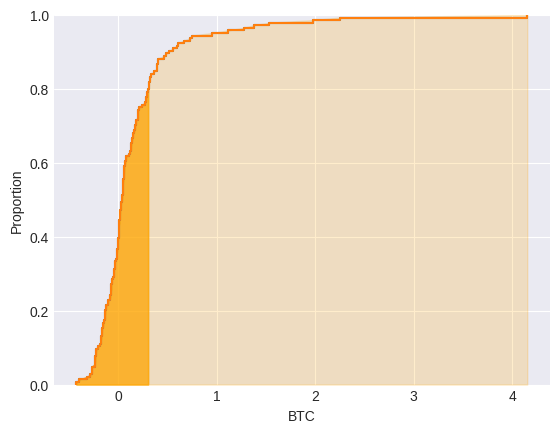

In [38]:
btc = sns.ecdfplot(monthly_returns["BTC"]).get_lines()[0].get_data()
btc_x = btc[0]
btc_y = btc[1]

sns.ecdfplot(monthly_returns['BTC'])
plt.fill_between(btc_x,btc_y, where = btc_y <=0.8, color='orange', alpha=0.8)
plt.fill_between(btc_x,btc_y, where = btc_y >=0.8, color='orange', alpha=0.2)
plt.savefig("btc_ecdf", dpi=300)
plt.show()
plt.clf()

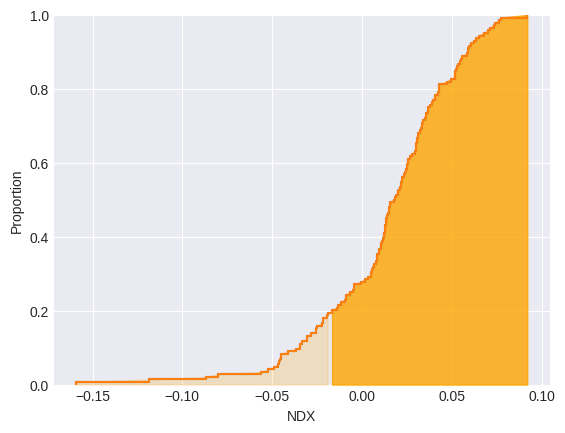

In [53]:
ndx = sns.ecdfplot(monthly_returns["NDX"]).get_lines()[0].get_data()
ndx_x = ndx[0]
ndx_y = ndx[1]

sns.ecdfplot(monthly_returns['NDX'])
plt.fill_between(ndx_x,ndx_y, where = ndx_y <=0.2, color='orange', alpha=0.2)
plt.fill_between(ndx_x,ndx_y, where = ndx_y >=0.2, color='orange', alpha=0.8)
plt.savefig("ndx_ecdf", dpi=300)
plt.show()


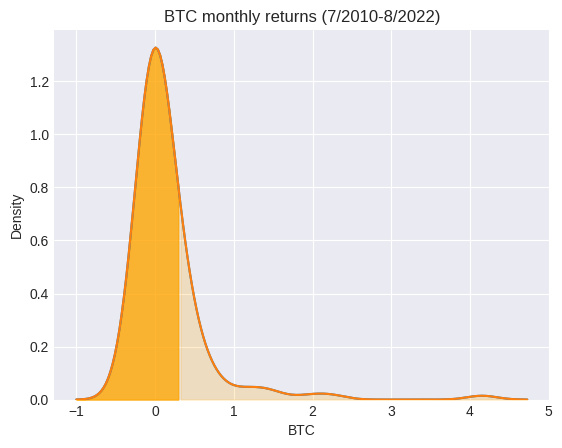

In [65]:
plt.clf()
btc = sns.kdeplot(monthly_returns["BTC"]).get_lines()[0].get_data()
btc_x = btc[0]
btc_y = btc[1]

sns.kdeplot(monthly_returns["BTC"])
plt.fill_between(btc_x[btc_x<=0.3], btc_y[btc_x<=0.3], color='orange', alpha=0.8)
plt.fill_between(btc_x[btc_x>=0.3], btc_y[btc_x>=0.3], color='orange', alpha=0.2)
plt.title("BTC monthly returns (7/2010-8/2022)")
plt.savefig("btc_pdf", dpi=300)
plt.show()

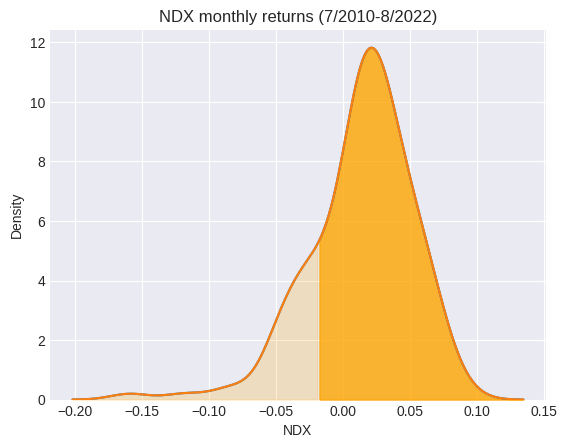

In [66]:
plt.clf()
ndx = sns.kdeplot(monthly_returns["NDX"]).get_lines()[0].get_data()
ndx_x = ndx[0]
ndx_y = ndx[1]

sns.kdeplot(monthly_returns["NDX"])
plt.fill_between(ndx_x[ndx_x<=-0.019], ndx_y[ndx_x<=-0.019], color='orange', alpha=0.2)
plt.fill_between(ndx_x[ndx_x>=-0.019], ndx_y[ndx_x>=-0.019], color='orange', alpha=0.8)
plt.title("NDX monthly returns (7/2010-8/2022)")
plt.savefig("ndx_pdf", dpi=300)
plt.show()

In [7]:
def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return drawdowns

def wealth_index(return_series, amount):
  return  amount*(1+return_series).cumprod()

def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4

import scipy.stats
def is_normal(r, level=0.01):
    """
    Applies the Jarque-Bera test to determine if a Series is normal or not
    Test is applied at the 1% level by default
    Returns True if the hypothesis of normality is accepted, False otherwise
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(is_normal)
    else:
        statistic, p_value = scipy.stats.jarque_bera(r)
        return p_value > level    

def semideviation(r):
    """
    Returns the semideviation aka negative semideviation of r
    r must be a Series or a DataFrame
    """
    is_negative = r < 0
    return r[is_negative].std(ddof=0)

def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [ ]:
print("Bitcoin monthly returns skewness", skewness(monthly_returns))
print("Bitcoin monthly returns kurtosis", kurtosis(monthly_returns))

Bitcoin monthly returns skewness BTC       4.321542
NASDAQ   -1.095216
dtype: float64
Bitcoin monthly returns kurtosis BTC       29.070154
NASDAQ     5.583812
dtype: float64


In [ ]:
print("Bitcoin daily returns skewness", skewness(daily_returns))
print("Bitcoin daily returns kurtosis", kurtosis(daily_returns))

Bitcoin daily returns skewness BTC       0.974923
NASDAQ   -0.420247
dtype: float64
Bitcoin daily returns kurtosis BTC       14.280513
NASDAQ     6.963965
dtype: float64


In [ ]:
semideviation(monthly_returns.dropna())

BTC       0.100512
NASDAQ    0.031030
dtype: float64

In [62]:
btc_var = var_historic(monthly_returns.dropna(), level=1)
btc_cvar = cvar_historic(monthly_returns.dropna(), level=1)
print("Bitcoin Value at Risk", btc_var)
print("Bitcoin Conditional Value at Risk", btc_cvar)

Bitcoin Value at Risk BTC    0.363504
NDX    0.104798
dtype: float64
Bitcoin Conditional Value at Risk BTC    0.411621
NDX    0.138690
dtype: float64


In [50]:
returns_drawdown = drawdown(daily_returns)

In [8]:
def get_annualized_sharpe_ratio(daily_returns):
  btc_sharpe = (((daily_returns["BTC"].rolling("365D").mean() - (0.03)/365) / daily_returns["BTC"].rolling("365D").std()*np.sqrt(365)))
  nasdaq_sharpe = (((daily_returns["NDX"].rolling("252D").mean() - (0.03)/252) / daily_returns["NDX"].rolling("252D").std()*np.sqrt(252)))
  btc_sharpe = pd.DataFrame(btc_sharpe, index=btc_sharpe.index, columns=["BTC"])
  nasdaq_sharpe = pd.DataFrame(nasdaq_sharpe, index=nasdaq_sharpe.index, columns=["NDX"])  
  return btc_sharpe.join(nasdaq_sharpe, how='outer').dropna()

In [9]:
annualized_sharpe_ratio = get_annualized_sharpe_ratio(daily_returns)
# annualized_sharpe_ratio

,BTC,NDX
Date,,
2010-07-21,-1.534538,15.851003
2010-07-22,-11.153006,24.162959
2010-07-23,-2.603329,19.922670
2010-07-27,-1.138565,22.029016
2010-07-28,-1.352267,11.629590
...,...,...
2022-07-20,-0.293693,-1.014412
2022-07-21,-0.503985,-0.935301
2022-07-22,-0.573371,-0.954243


In [47]:
good_btc_sharpe = annualized_sharpe_ratio.loc["2011":,"BTC"] >= annualized_sharpe_ratio.loc["2011":,"NDX"]

In [101]:
good_btc_sharpe.sum() / len(good_btc_sharpe)

0.7045688766746823

<Figure size 640x480 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

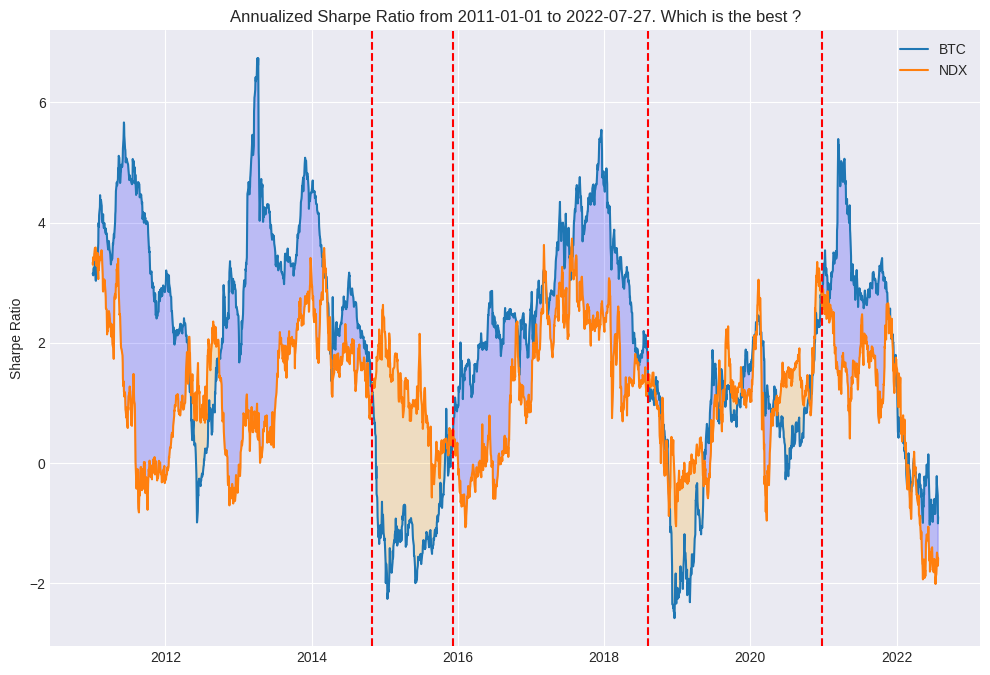

In [48]:
plt.clf()
plt.figure(figsize=(12,8))
plt.plot(annualized_sharpe_ratio["2011":])
plt.fill_between(annualized_sharpe_ratio.loc["2011":].index, annualized_sharpe_ratio.loc["2011":,"NDX"].to_numpy(),annualized_sharpe_ratio.loc["2011":,"BTC"].to_numpy(), where = good_btc_sharpe.to_numpy(), color='blue', alpha=0.2)
plt.fill_between(annualized_sharpe_ratio.loc["2011":].index, annualized_sharpe_ratio.loc["2011":,"BTC"].to_numpy(),annualized_sharpe_ratio.loc["2011":,"NDX"].to_numpy(), where = ~good_btc_sharpe.to_numpy(), color='orange', alpha=0.2)
plt.axvline(x=datetime.datetime(2014,10,29), color='red', linestyle='--')
plt.axvline(x=datetime.datetime(2015,12,8), color='red', linestyle='--')
plt.axvline(x=datetime.datetime(2018,8,8), color='red', linestyle='--')
plt.axvline(x=datetime.datetime(2020,12,22), color='red', linestyle='--')
plt.legend(['BTC', 'NDX'])
plt.ylabel("Sharpe Ratio")
plt.title("Annualized Sharpe Ratio from 2011-01-01 to 2022-07-27. Which is the best ?")
plt.savefig("annualized_sharpe_ratio", dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

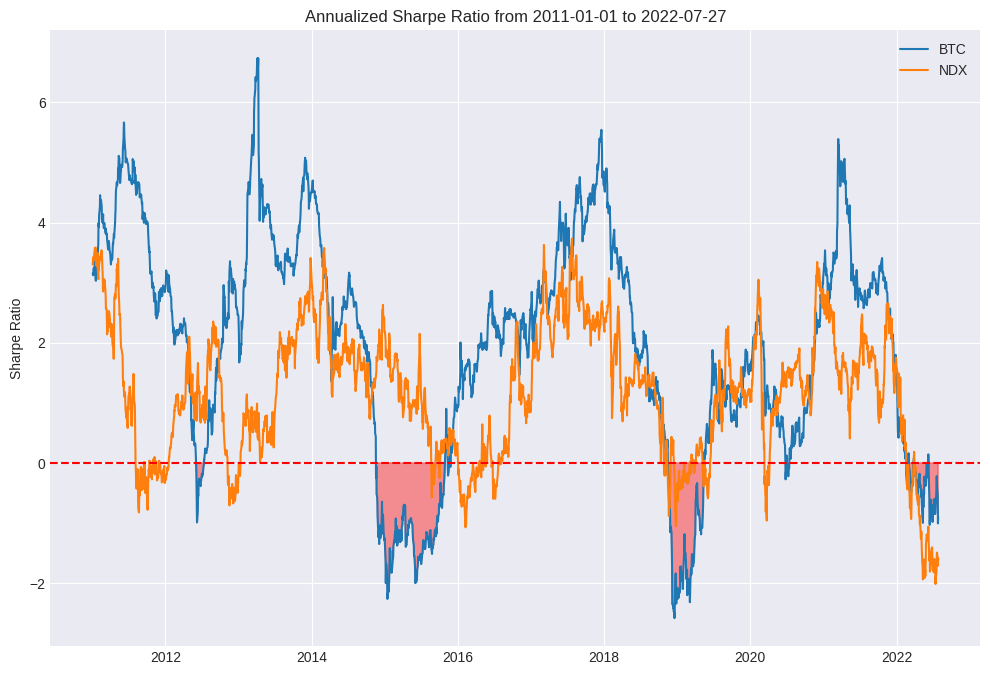

In [63]:
plt.clf()
plt.figure(figsize=(12,8))
plt.plot(annualized_sharpe_ratio["2011":])
plt.fill_between(annualized_sharpe_ratio.loc["2011":].index, 0, annualized_sharpe_ratio.loc["2011":,"BTC"].to_numpy(), where = annualized_sharpe_ratio.loc["2011":,"BTC"]<=0, color='red', alpha=0.4)
plt.axhline(y=0, color='red', linestyle='--')
plt.legend(['BTC', 'NDX'])
plt.title("Annualized Sharpe Ratio from 2011-01-01 to 2022-07-27")
plt.ylabel("Sharpe Ratio")
plt.savefig("negative_sharpe_ratio", dpi=300)
plt.show()

In [135]:
print((annualized_sharpe_ratio.loc["2011":,"BTC"]<=0).to_string())

Date
2011-01-03    False
2011-01-04    False
2011-01-05    False
2011-01-06    False
2011-01-07    False
2011-01-10    False
2011-01-11    False
2011-01-12    False
2011-01-13    False
2011-01-14    False
2011-01-18    False
2011-01-19    False
2011-01-20    False
2011-01-21    False
2011-01-24    False
2011-01-25    False
2011-01-26    False
2011-01-27    False
2011-01-28    False
2011-01-31    False
2011-02-01    False
2011-02-02    False
2011-02-03    False
2011-02-04    False
2011-02-07    False
2011-02-08    False
2011-02-09    False
2011-02-10    False
2011-02-11    False
2011-02-14    False
2011-02-15    False
2011-02-16    False
2011-02-17    False
2011-02-18    False
2011-02-22    False
2011-02-23    False
2011-02-24    False
2011-02-25    False
2011-02-28    False
2011-03-01    False
2011-03-02    False
2011-03-03    False
2011-03-04    False
2011-03-07    False
2011-03-08    False
2011-03-09    False
2011-03-10    False
2011-03-11    False
2011-03-14    False
2011-03-15    F

In [11]:
print((annualized_sharpe_ratio.loc["2011":,"BTC"] >=5).to_string())

Date
2011-01-04    False
2011-01-05    False
2011-01-06    False
2011-01-07    False
2011-01-11    False
2011-01-12    False
2011-01-13    False
2011-01-14    False
2011-01-19    False
2011-01-20    False
2011-01-21    False
2011-01-25    False
2011-01-26    False
2011-01-27    False
2011-01-28    False
2011-02-01    False
2011-02-02    False
2011-02-03    False
2011-02-04    False
2011-02-08    False
2011-02-09     True
2011-02-10    False
2011-02-11    False
2011-02-15    False
2011-02-16    False
2011-02-17    False
2011-02-18    False
2011-02-23    False
2011-02-24    False
2011-02-25    False
2011-03-01    False
2011-03-02    False
2011-03-03    False
2011-03-04    False
2011-03-08    False
2011-03-09    False
2011-03-10    False
2011-03-11    False
2011-03-15    False
2011-03-16    False
2011-03-17    False
2011-03-18    False
2011-03-22    False
2011-03-23    False
2011-03-24    False
2011-03-25    False
2011-03-29    False
2011-03-30    False
2011-03-31    False
2011-04-01    F

<Figure size 640x480 with 0 Axes>

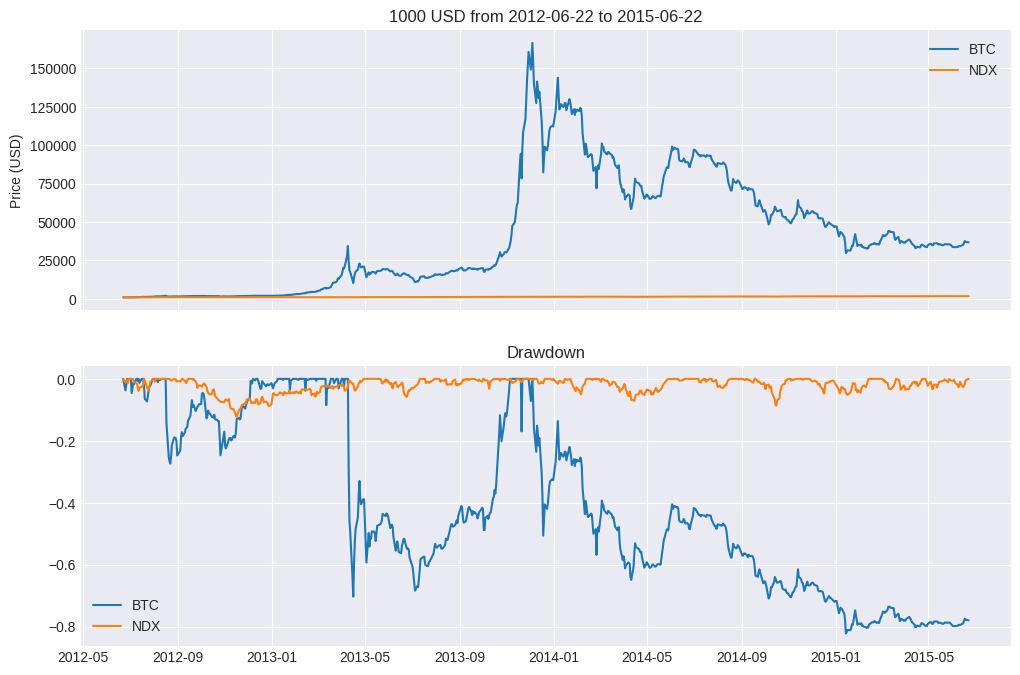

In [59]:
wealth = wealth_index(daily_returns["2012-06-22":"2015-06-22"], 1000)
returns_drawdown = drawdown(daily_returns["2012-06-22":"2015-06-22"])
plt.clf()
f, (ax2, ax3) = plt.subplots(2, 1, figsize=(12,8), sharex=True)
# ax1.plot(np.log(daily_price))
# ax1.set_title('Bitcoin daily price - log scale')
# ax1.grid(True)
ax2.plot(wealth)
ax2.set_title("1000 USD from 2012-06-22 to 2015-06-22")
ax2.legend(['BTC', 'NDX'])
ax2.set_ylabel("Price (USD)")

ax3.plot(returns_drawdown)
ax3.set_title('Drawdown')
ax3.legend(['BTC', 'NDX'])
plt.savefig("period_1", dpi=300)
plt.show()
# plt.savefig("risk_analysis", dpi=300)

<Figure size 640x480 with 0 Axes>

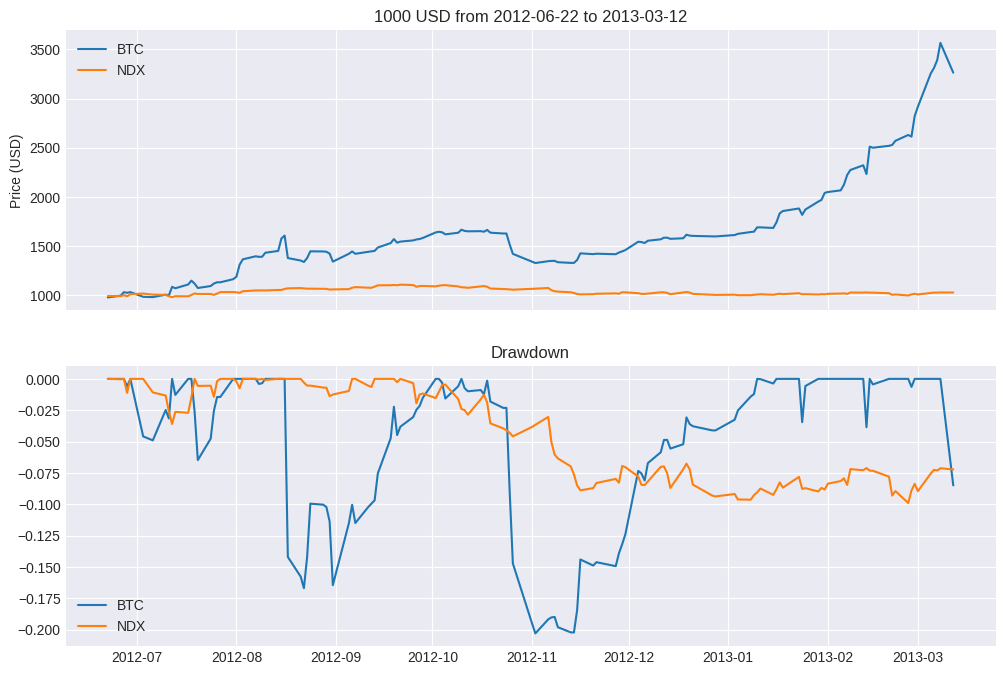

In [12]:
wealth = wealth_index(daily_returns["2012-06-22":"2013-03-12"], 1000)
returns_drawdown = drawdown(daily_returns["2012-06-22":"2013-03-12"])
plt.clf()
f, (ax2, ax3) = plt.subplots(2, 1, figsize=(12,8), sharex=True)
# ax1.plot(np.log(daily_price))
# ax1.set_title('Bitcoin daily price - log scale')
# ax1.grid(True)
ax2.plot(wealth)
ax2.set_title("1000 USD from 2012-06-22 to 2013-03-12")
ax2.legend(['BTC', 'NDX'])
ax2.set_ylabel("Price (USD)")

ax3.plot(returns_drawdown)
ax3.set_title('Drawdown')
ax3.legend(['BTC', 'NDX'])
plt.savefig("period_1", dpi=300)
plt.show()
# plt.savefig("risk_analysis", dpi=300)

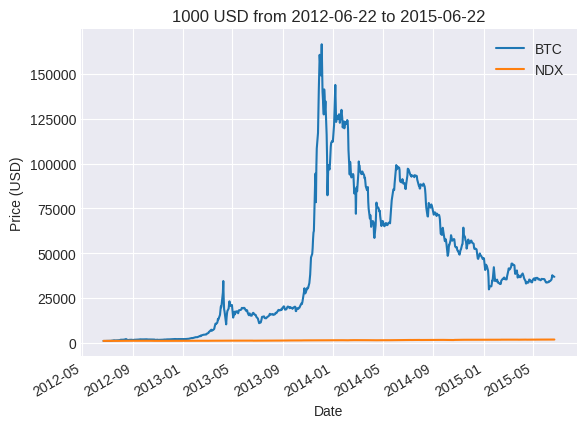

In [42]:
wealth = wealth_index(daily_returns["2012-06-22":"2015-06-22"], 1000)
wealth.plot()
plt.title("1000 USD from 2012-06-22 to 2015-06-22")
plt.legend(['BTC', 'NDX'])
plt.ylabel("Price (USD)")
plt.savefig("period_1", dpi=300)
plt.show()


In [19]:
wealth.iloc[-1]

BTC    36803.041871
NDX     1756.233310
Name: 2015-06-22 00:00:00, dtype: float64

In [38]:
print(np.power(36.803,1/3)-1)
print(np.power(1.756,1/3)-1)

2.3262973812852192
0.20644678525931748


<Figure size 640x480 with 0 Axes>

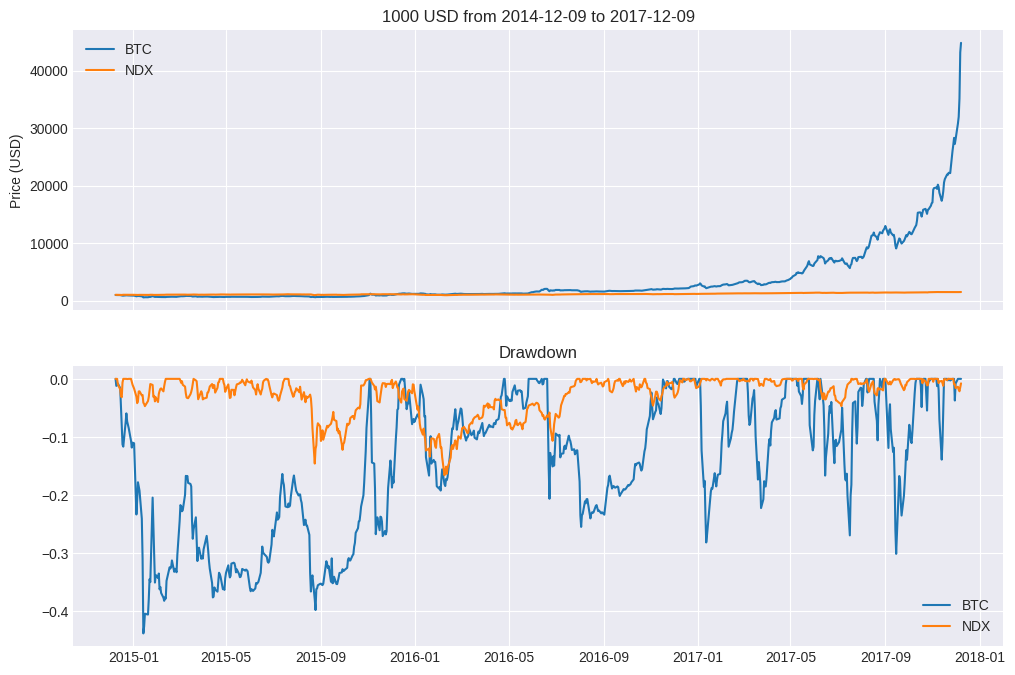

In [61]:
# wealth = wealth_index(daily_returns["2014-12-09":"2017-12-09"], 1000)
# wealth.plot()
# plt.title("1000 USD from 2014-12-09 to 2017-12-09")
# plt.ylabel("Price (USD)")
# plt.legend(['BTC', 'NDX'])
# plt.savefig("period_2", dpi=300)
# plt.show()

wealth = wealth_index(daily_returns["2014-12-09":"2017-12-09"], 1000)
returns_drawdown = drawdown(daily_returns["2014-12-09":"2017-12-09"])
plt.clf()
f, (ax2, ax3) = plt.subplots(2, 1, figsize=(12,8), sharex=True)
# ax1.plot(np.log(daily_price))
# ax1.set_title('Bitcoin daily price - log scale')
# ax1.grid(True)
ax2.plot(wealth)
ax2.set_title("1000 USD from 2014-12-09 to 2017-12-09")
ax2.legend(['BTC', 'NDX'])
ax2.set_ylabel("Price (USD)")

ax3.plot(returns_drawdown)
ax3.set_title('Drawdown')
ax3.legend(['BTC', 'NDX'])
plt.savefig("period_2", dpi=300)
plt.show()
# plt.savefig("risk_analysis", dpi=300)

In [21]:
wealth.iloc[-1]

BTC    44820.084014
NDX     1481.833157
Name: 2017-12-08 00:00:00, dtype: float64

In [37]:
print(np.power(44.820,1/3)-1)
print(np.power(1.481,1/3)-1)

2.5521444426286948
0.13986045280692116


<Figure size 640x480 with 0 Axes>

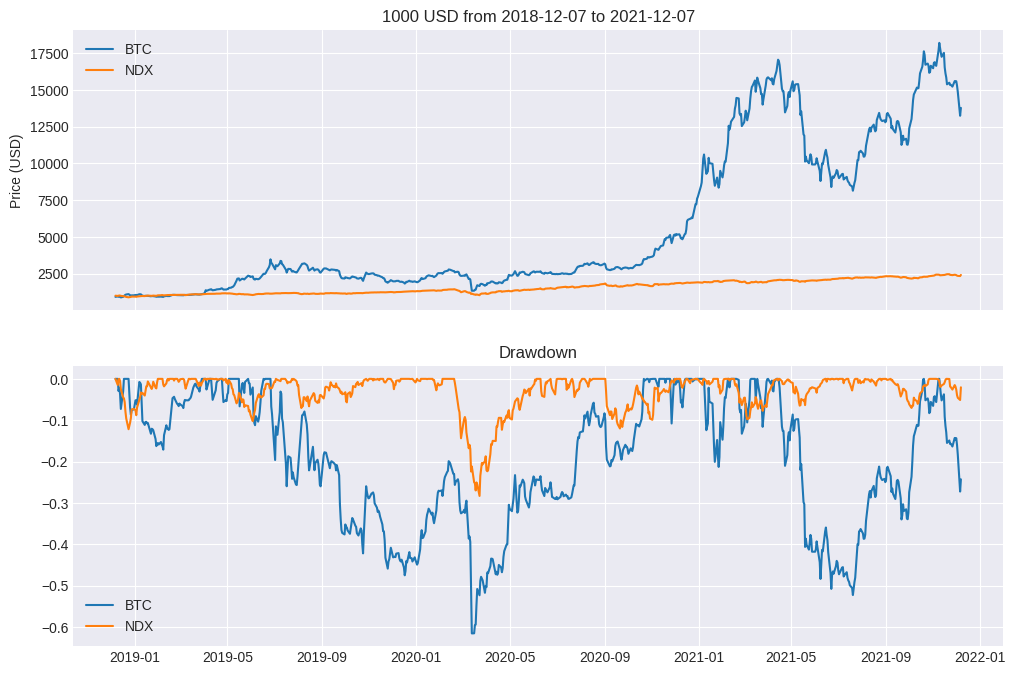

In [60]:
# wealth = wealth_index(daily_returns["2018-12-07":"2021-12-07"], 1000)
# wealth.plot()
# plt.title("1000 USD from 2018-12-07 to 2021-12-07")
# plt.ylabel("Price (USD)")
# plt.legend(['BTC', 'NDX'])
# plt.savefig("period_3", dpi=300)
# plt.show()

wealth = wealth_index(daily_returns["2018-12-07":"2021-12-07"], 1000)
returns_drawdown = drawdown(daily_returns["2018-12-07":"2021-12-07"])
plt.clf()
f, (ax2, ax3) = plt.subplots(2, 1, figsize=(12,8), sharex=True)
# ax1.plot(np.log(daily_price))
# ax1.set_title('Bitcoin daily price - log scale')
# ax1.grid(True)
ax2.plot(wealth)
ax2.set_title('1000 USD from 2018-12-07 to 2021-12-07')
ax2.legend(['BTC', 'NDX'])
ax2.set_ylabel("Price (USD)")
ax3.plot(returns_drawdown)
ax3.set_title('Drawdown')
ax3.legend(['BTC', 'NDX'])
plt.savefig("period_3", dpi=300)
plt.show()

In [25]:
wealth.iloc[-1]

BTC    13772.699884
NDX     2410.462433
Name: 2021-12-07 00:00:00, dtype: float64

In [36]:
print(np.power(13.772,1/3)-1)
print(np.power(2.410,1/3)-1)

1.3969869596519802
0.34072285940982905


In [110]:
1-good_btc_sharpe["2018-08-08":"2020-12-22"].sum() / len(good_btc_sharpe["2018-08-08":"2020-12-22"])

0.6343906510851419

In [119]:
datetime.datetime(2022,7,27) - datetime.datetime(2020,12,22) 

datetime.timedelta(days=582)

In [120]:
datetime.datetime(2020,12,22)  - datetime.datetime(2018,8,8)

datetime.timedelta(days=867)

In [121]:
datetime.datetime(2018,8,8)-datetime.datetime(2015,12,8)

datetime.timedelta(days=974)

In [122]:
datetime.datetime(2015,12,8) - datetime.datetime(2014,10,29)

datetime.timedelta(days=405)

In [123]:
 datetime.datetime(2014,10,29) -  datetime.datetime(2011,1,1)

datetime.timedelta(days=1397)

In [99]:
daily_returns.iloc[-1]

BTC    0.046046
NDX    0.024989
Name: 2022-07-27 00:00:00, dtype: float64